In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import numpy as np

# Configuração de estilo
plt.style.use('ggplot')
sns.set_palette("pastel")

# Carregar os dados
df = pd.read_parquet(r'..\data/dataset_valid_with_sentiment.parquet')

=== DISTRIBUIÇÃO DE SENTIMENTOS ===
sentiment
Positive    62.311558
Negative    25.125628
Neutral     12.562814
Name: proportion, dtype: float64


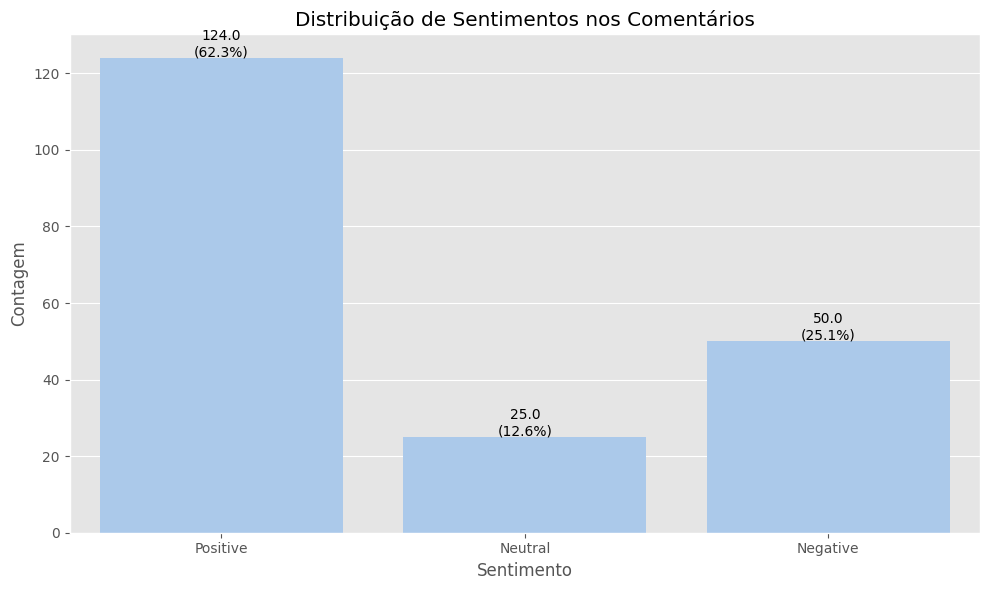


=== PRINCIPAIS TÓPICOS POR SENTIMENTO ===


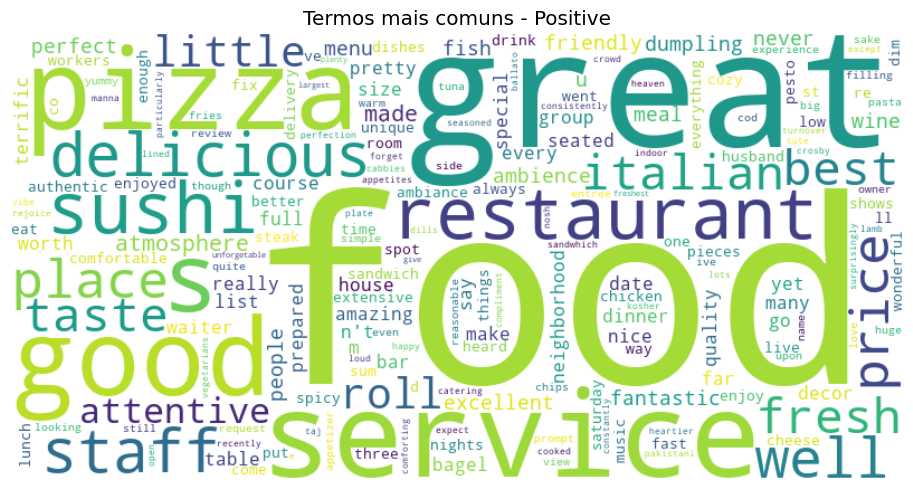

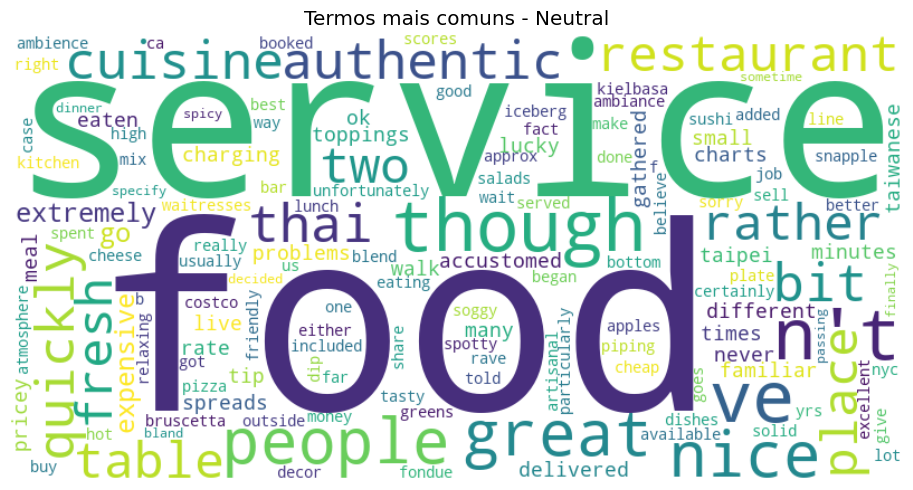

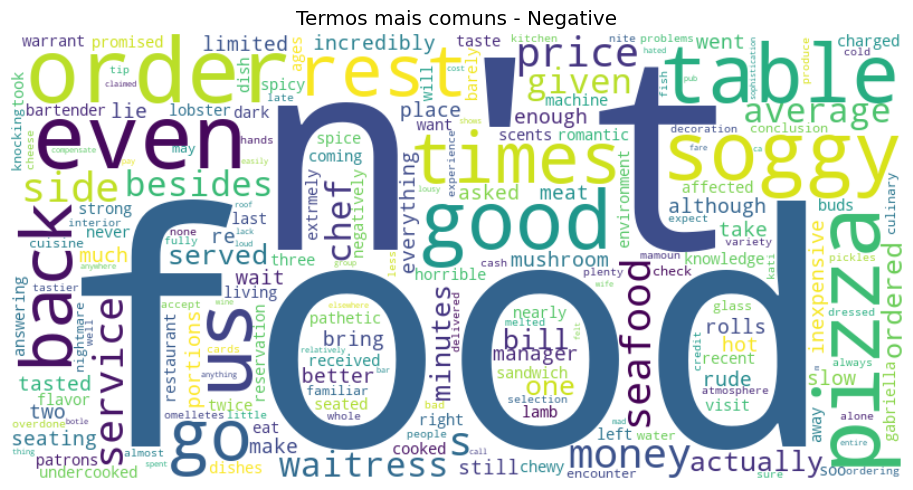


=== ANÁLISE DE METADADOS ===


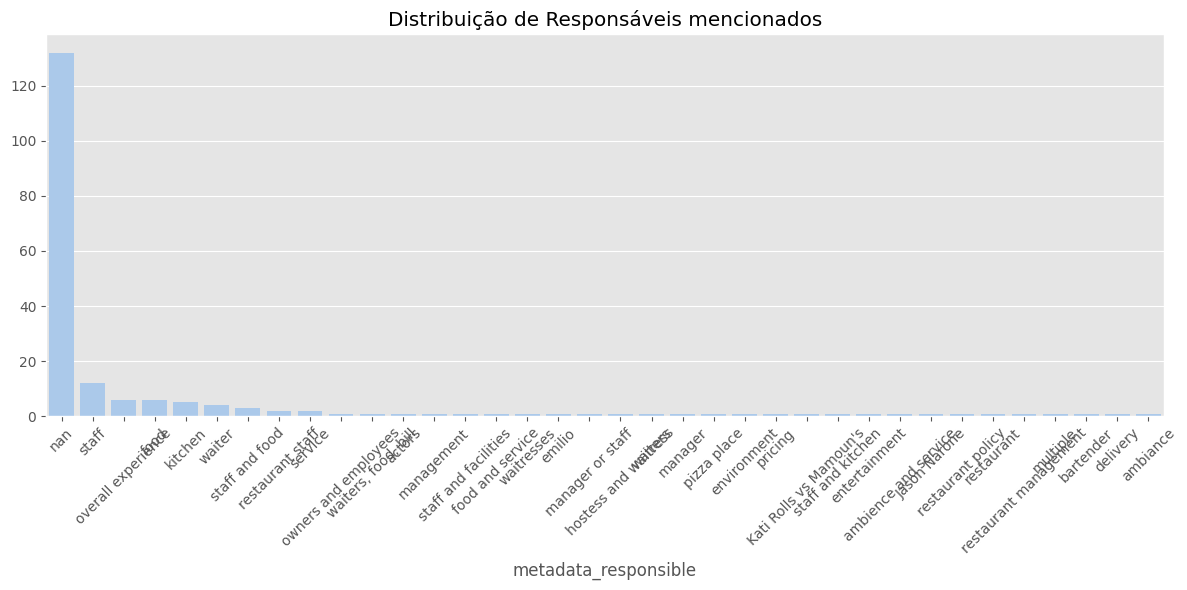


=== PRINCIPAIS RAZÕES PARA SENTIMENTOS ===

Top razões para comentários positivos:
[('good food', 2), ('friendly', 2), ('food quality', 2), ('good food and convenient location', 1), ('cozy and cute ambiance', 1), ('delicious authentic italian food', 1), ('focus on food quality', 1), ('delicious food', 1), ('amazing time', 1), ('surprisingly fresh food due to high turnover', 1)]

Top razões para comentários negativos:
[('slow service', 2), ('below average knowledge', 1), ('multiple service errors including incorrect seating, wrong orders, delayed and undercooked food, and overcharging', 1), ('rude behavior', 1), ('strong scents affected taste buds', 1), ('overpriced', 1), ('bad food, poor service, dishonesty', 1), ('under-cooked and chewy lamb meat', 1), ('outdated reservation system', 1), ('excessive spiciness and loss of flavor', 1)]

=== COMPRIMENTO DO TEXTO POR SENTIMENTO ===


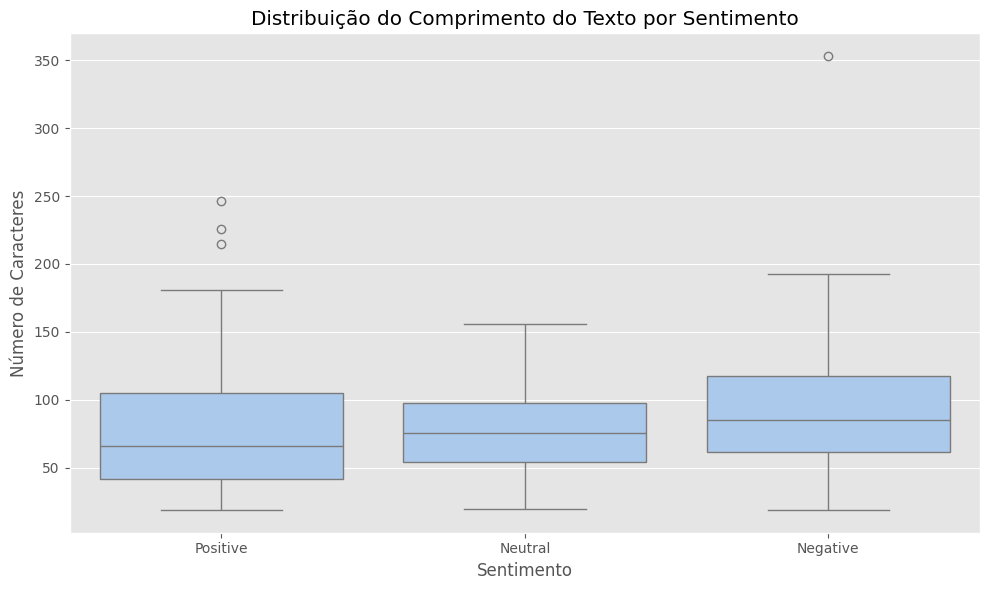


=== MATRIZ DE CORRELAÇÃO ===


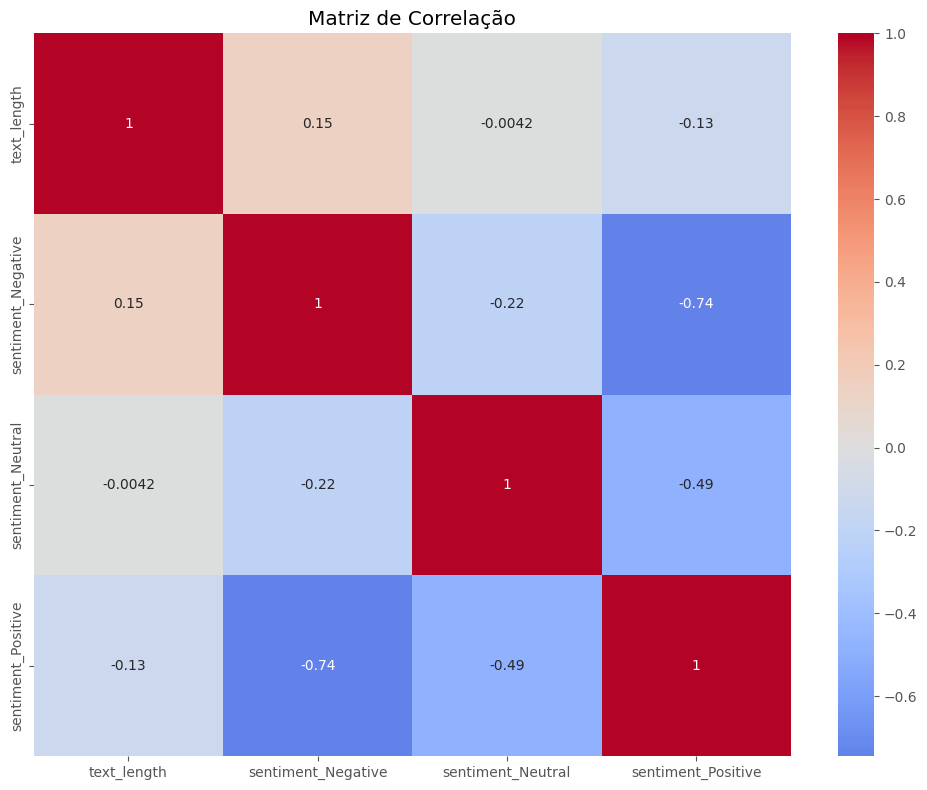


=== TERMOS ESPECÍFICOS POR SENTIMENTO ===

Análise para o termo: 'service'
sentiment
Positive    66.666667
Neutral     20.833333
Negative    12.500000
Name: proportion, dtype: float64

Análise para o termo: 'food'
sentiment
Positive    48.837209
Negative    34.883721
Neutral     16.279070
Name: proportion, dtype: float64

Análise para o termo: 'price'
sentiment
Positive    66.666667
Negative    25.000000
Neutral      8.333333
Name: proportion, dtype: float64

Análise para o termo: 'wait'
sentiment
Negative    50.0
Positive    30.0
Neutral     20.0
Name: proportion, dtype: float64

Análise para o termo: 'staff'
sentiment
Positive    100.0
Name: proportion, dtype: float64


In [13]:
## 1. Análise Básica de Sentimentos
print("=== DISTRIBUIÇÃO DE SENTIMENTOS ===")
sentiment_dist = df['sentiment'].value_counts(normalize=True) * 100
print(sentiment_dist)

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribuição de Sentimentos nos Comentários')
plt.xlabel('Sentimento')
plt.ylabel('Contagem')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df)*100:.1f}%)', 
                (p.get_x() + p.get_width()/2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.tight_layout()
plt.savefig('sentiment_distribution.png')
plt.show()

## 2. Análise Temporal (se houver data)
if 'date' in df.columns:
    print("\n=== ANÁLISE TEMPORAL ===")
    df['date'] = pd.to_datetime(df['date'])
    df['month_year'] = df['date'].dt.to_period('M')
    
    monthly_sentiment = df.groupby(['month_year', 'sentiment']).size().unstack()
    monthly_sentiment.plot(kind='line', figsize=(12, 6))
    plt.title('Evolução Mensal dos Sentimentos')
    plt.ylabel('Número de Comentários')
    plt.xlabel('Mês/Ano')
    plt.tight_layout()
    plt.savefig('monthly_sentiment.png')
    plt.show()

## 3. Análise de Tópicos por Sentimento
print("\n=== PRINCIPAIS TÓPICOS POR SENTIMENTO ===")

def generate_wordcloud(texts, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'wordcloud_{title.lower()}.png')
    plt.show()

# Wordclouds para cada sentimento
for sentiment in ['Positive', 'Neutral', 'Negative']:
    texts = df[df['sentiment'] == sentiment]['comment_cleaned'].dropna()
    if not texts.empty:
        generate_wordcloud(texts, f'Termos mais comuns - {sentiment}')

## 4. Análise de Metadados
print("\n=== ANÁLISE DE METADADOS ===")
if 'metadata_responsible' in df.columns:
    plt.figure(figsize=(12, 6))
    responsible_counts = df['metadata_responsible'].value_counts()
    ax = sns.barplot(x=responsible_counts.index, y=responsible_counts.values)
    plt.title('Distribuição de Responsáveis mencionados')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('responsible_distribution.png')
    plt.show()

## 5. Análise de Razões (Reasons)
if 'metadata_reason' in df.columns:
    print("\n=== PRINCIPAIS RAZÕES PARA SENTIMENTOS ===")
    
    # Para sentimentos positivos
    positive_reasons = df[df['sentiment'] == 'Positive']['metadata_reason'].dropna()
    if not positive_reasons.empty:
        print("\nTop razões para comentários positivos:")
        print(Counter(positive_reasons).most_common(10))
    
    # Para sentimentos negativos
    negative_reasons = df[df['sentiment'] == 'Negative']['metadata_reason'].dropna()
    if not negative_reasons.empty:
        print("\nTop razões para comentários negativos:")
        print(Counter(negative_reasons).most_common(10))

## 6. Análise de Comprimento do Texto vs. Sentimento
print("\n=== COMPRIMENTO DO TEXTO POR SENTIMENTO ===")
df['text_length'] = df['comment_cleaned'].str.len()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='sentiment', y='text_length', order=['Positive', 'Neutral', 'Negative'])
plt.title('Distribuição do Comprimento do Texto por Sentimento')
plt.xlabel('Sentimento')
plt.ylabel('Número de Caracteres')
plt.tight_layout()
plt.savefig('text_length_by_sentiment.png')
plt.show()

## 7. Correlação entre Variáveis (se aplicável)
print("\n=== MATRIZ DE CORRELAÇÃO ===")
# Criar variáveis dummy para sentimentos
sentiment_dummies = pd.get_dummies(df['sentiment'], prefix='sentiment')

# Juntar com outras variáveis numéricas
analysis_df = pd.concat([df.select_dtypes(include=[np.number]), sentiment_dummies], axis=1)

# Calcular e plotar matriz de correlação
if len(analysis_df.columns) > 1:
    plt.figure(figsize=(10, 8))
    sns.heatmap(analysis_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Matriz de Correlação')
    plt.tight_layout()
    plt.savefig('correlation_matrix.png')
    plt.show()

## 8. Análise de Emoções Específicas (exemplo)
print("\n=== TERMOS ESPECÍFICOS POR SENTIMENTO ===")
keywords = ['service', 'food', 'price', 'wait', 'staff']  # Adapte para seu contexto

for keyword in keywords:
    print(f"\nAnálise para o termo: '{keyword}'")
    keyword_df = df[df['comment_cleaned'].str.contains(keyword, case=False, na=False)]
    if not keyword_df.empty:
        print(keyword_df['sentiment'].value_counts(normalize=True) * 100)


In [14]:
## 9. Exportar relatório completo
print("\n=== EXPORTANDO RELATÓRIO COMPLETO ===")
with open('analise_sentimentos.txt', 'w', encoding='utf-8') as f:
    f.write("=== RELATÓRIO DE ANÁLISE DE SENTIMENTOS ===\n\n")
    f.write(f"Total de comentários analisados: {len(df)}\n\n")
    
    f.write("=== DISTRIBUIÇÃO DE SENTIMENTOS ===\n")
    f.write(sentiment_dist.to_string())
    f.write("\n\n")
    
    if 'metadata_reason' in df.columns:
        f.write("=== PRINCIPAIS RAZÕES ===\n")
        f.write("Comentários Positivos:\n")
        f.write(str(Counter(positive_reasons).most_common(10)))
        f.write("\n\nComentários Negativos:\n")
        f.write(str(Counter(negative_reasons).most_common(10)))
        f.write("\n\n")

print("Análise concluída! Verifique os gráficos gerados e o arquivo 'analise_sentimentos.txt'")


=== EXPORTANDO RELATÓRIO COMPLETO ===
Análise concluída! Verifique os gráficos gerados e o arquivo 'analise_sentimentos.txt'
